In [3]:
import pickle
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import pandas as pd

In [4]:
city = 'Winterswijk'

In [5]:
with open(f'../networks/escape_nodes_{city}.pkl', 'rb') as f:
    escape_nodes = pickle.load(f)

with open(f'../results/coarsened_network_{city}.pkl', 'rb') as f:
    G = pickle.load(f)

# import routes generated on coarsened graph
with open(f'../results/results_routes_{city}_100.pkl', 'rb') as f:
    route_fugitive = pickle.load(f)

In [6]:
G.graph['crs'] = 4326
fugitive_start = ox.nearest_nodes(G, 6.715503611053481, 51.97037617480607)  # bank

# import start police
police_addresses = [{'lat': 51.96730689392284, 'lon': 6.717868176220198},  # Dingstraat 38
                    {'lat': 51.93473914644306, 'lon': 6.808688143805569},  # Duitsland Oost
                    {'lat': 52.03601213823647, 'lon': 6.822783925913308},  # Duitsland Noord
                    ]

start_police = []
for pol in police_addresses:
    node = ox.nearest_nodes(G, pol['lon'], pol['lat'])
    start_police.append(node)

# import delays police
with open(f'../networks/delays_police_{city}.pkl', 'rb') as f:
    delays_police = pickle.load(f)

In [7]:
with open(f'../results/results_positions_{city}.pkl', 'rb') as f:
    opstelpos = pickle.load(f)

In [8]:
#unlabeled for plotting
routes = [list(route.values()) for route in route_fugitive]

In [10]:
filepath = f"../networks/{city}.graph.graphml"
G_orig = ox.load_graphml(filepath)

In [22]:
# G_merge = G_orig.copy()
# 
# #FIRST DO THE EDGES
# for u, v in G_orig.edges():
#     G_merge.remove_edge(u, v)
# 
# for u, v, data 
# 
# for node, data in G_orig.nodes(data=True):
#     if node not in G.nodes():
#         G_merge.remove_node(node)
#         
# for node, data in G.nodes(data=True):
#     if 'removed_nodes' not in data.keys():
#         print(data)
#     else:
#         nx.set_node_attributes(G_merge, {node: {'removed_nodes': data['removed_nodes']}})

In [14]:
G[node]

AtlasView({44405728: {'osmid': [6692690, 896012349, 114575446, 6694951], 'highway': 'tertiary', 'oneway': False, 'reversed': False, 'length': 2012.5160000000003, 'geometry': <LINESTRING (6.648 51.911, 6.656 51.912, 6.656 51.912, 6.657 51.912, 6.657 5...>, 'speed_kph': 60.0, 'travel_time': 120.8, 'name': ['Boomkampweg', 'Driehonderdmeterweg'], 'surface': ['paving_stones', 'asphalt'], 'lanes': '1', 'maxspeed': '60', 'index_right': '0', 'identificatie': 'LND6030', 'naam': 'Nederland', 'code': '6030', 'id': 4, 'weight': 0.2, 'removed_nodes': [], 'removed_links': [(44353900, 44405728)], 'neighbors': [5, 7, 8, 9, 11, 112, 93]}, 44424610: {'osmid': [1097714306, 1097714307, 6695116, 611818253, 611818254], 'highway': 'tertiary', 'oneway': False, 'reversed': False, 'length': 1743.3600000000001, 'geometry': <LINESTRING (6.648 51.911, 6.648 51.913, 6.648 51.914, 6.648 51.915, 6.647 5...>, 'speed_kph': 60.0, 'travel_time': 104.6, 'name': 'Spiekerdijk', 'surface': 'asphalt', 'maxspeed': '60', 'index

In [9]:
def draw_nodes(G, fugitive_start, border_crossings, cameras, positions):
    node_size = []
    node_color = []
    for node in G.nodes:
        if node == fugitive_start:
            node_size.append(40)
            node_color.append('tab:orange')
        elif node in positions:
            node_size.append(30)
            node_color.append('tab:blue')
        elif node in escape_nodes:
            node_size.append(40)
            node_color.append('tab:red')
        elif node in border_crossings:
            node_size.append(15)
            node_color.append('tab:gray')
        elif node in cameras:
            node_size.append(10)
            node_color.append('tab:green')

        else:
            node_size.append(0)
            node_color.append('lightgray')
    return node_size, node_color



def draw_edges(graph):
    edges_fugitive = []

    # for i_r, route_time in enumerate(fugitive_routes):
    #     route = list(route_time.values())
    #     for i, node in enumerate(route):
    #         if i ==0:
    #             continue
    #         else:
    #             edges_fugitive1 = [(route[i], route[i-1])]
    #             edges_fugitive2 = [(route[i-1], route[i])]
    #             edges_fugitive.extend(tuple(edges_fugitive1))
    #             edges_fugitive.extend(tuple(edges_fugitive2))

    edge_colormap = ['lightgray'] * len(graph.edges())
    edge_weightmap = [1] * len(graph.edges())
    for index, edge in enumerate(graph.edges()):
        if edge in edges_fugitive:
            edge_colormap[index] = 'tab:orange'
            edge_weightmap[index] = 2

    return edge_colormap, edge_weightmap

In [10]:
def get_intercepted_routes(route_fugitive, police_start, results_positions):
    z_r = {}
    pi_nodes = {}

    for u, associated_node in enumerate(results_positions):
        travel_time_to_target = nx.shortest_path_length(G,
                                                      source=police_start[u],
                                                      target=associated_node,
                                                      weight='travel_time',
                                                      method='bellman-ford')
        pi_nodes[u] = (associated_node, travel_time_to_target)

    for i_r, _ in enumerate(route_fugitive):
        z_r[i_r] = 0

    for i_r, r in enumerate(route_fugitive):  # for each route
        if any([node in results_positions for node in r.values()]):
            for u, pi in pi_nodes.items():  # for each police unit
                for time_at_node_fugitive, node_fugitive in r.items():  # for each node in the fugitive route
                    if node_fugitive == pi[0]:  # if the fugitive node is the same as the target node of the police unit
                        if time_at_node_fugitive > pi[1]:  # and the police unit can reach that node
                            z_r[i_r] = 1  # intercepted

    # print(sum(z_r.values())/len(route_fugitive))

    return z_r

In [11]:
intercepted_routes = get_intercepted_routes(route_fugitive=route_fugitive, police_start=opstelpos, results_positions=opstelpos)

In [12]:
print(sum(intercepted_routes.values())/len(route_fugitive))

1.0


In [13]:
route_colors = ['tab:blue' if val == 1 else 'tab:red' if val == 0 else ValueError for val in intercepted_routes.values()]
# route_colors += ['tab:blue' for pol in opstelpos]
route_alphas = [0.05 for fug in intercepted_routes]
# route_alphas += [1 for pol in opstelpos]

node_size, node_color = draw_nodes(G, fugitive_start, [], [], opstelpos)
edge_colormap, edge_weightmap = draw_edges(G)

In [18]:
length_dict = {}
count = 0
G_filtered = G.copy()
for u, v, data in G.edges(data=True):
    if 'travel_time' in data.keys():
        length_dict[(u, v)] = {'length': float(data['travel_time'])}
    else:
        G_filtered.remove_edge(u, v)
        count+= 1
        # length_dict[(u, v)] = {'length': 1}
count

75

In [19]:
nx.set_edge_attributes(G_filtered, length_dict)

TypeError: list indices must be integers or slices, not str

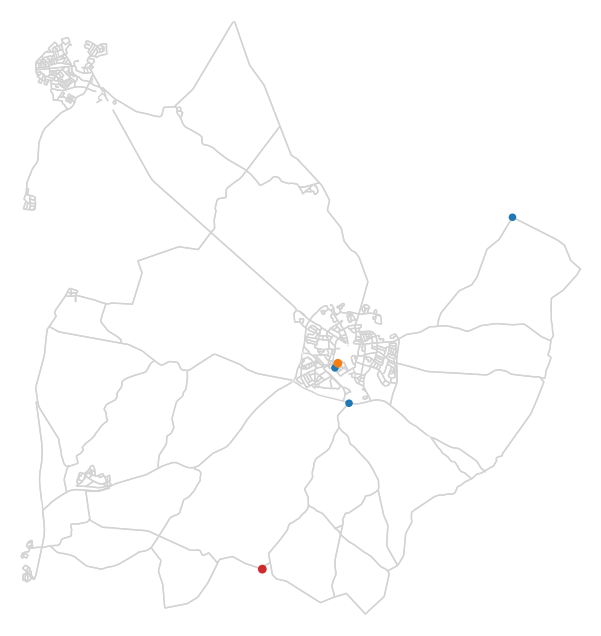

In [20]:
fig, ax = ox.plot_graph_routes(G_filtered, routes,
                               route_linewidths=[0.8]*len(routes), route_alpha=0.05, route_colors=route_colors,
                               edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                               node_color=node_color, node_size=node_size,
                               bgcolor="white",
                               orig_dest_size=30,
                               show=False,
                               # orig_dest_node_color=['tab:orange', 'tab:red']*len(results_routes),
                               )

In [25]:
for u,v in G_filtered.edges():
    print(u, v, G_filtered.get_edge_data(u, v))
    # min(G.get_edge_data(u, v).values(), key=lambda d: d["length"])

44353900 44405728 {'osmid': [6692690, 896012349, 114575446, 6694951], 'highway': 'tertiary', 'oneway': False, 'reversed': False, 'length': 120.8, 'geometry': <LINESTRING (6.648 51.911, 6.656 51.912, 6.656 51.912, 6.657 51.912, 6.657 5...>, 'speed_kph': 60.0, 'travel_time': 120.8, 'name': ['Boomkampweg', 'Driehonderdmeterweg'], 'surface': ['paving_stones', 'asphalt'], 'lanes': '1', 'maxspeed': '60', 'index_right': '0', 'identificatie': 'LND6030', 'naam': 'Nederland', 'code': '6030', 'id': 4, 'weight': 0.2, 'removed_nodes': [], 'removed_links': [(44353900, 44405728)], 'neighbors': [5, 7, 8, 9, 11, 112, 93]}
44353900 44424610 {'osmid': [1097714306, 1097714307, 6695116, 611818253, 611818254], 'highway': 'tertiary', 'oneway': False, 'reversed': False, 'length': 104.6, 'geometry': <LINESTRING (6.648 51.911, 6.648 51.913, 6.648 51.914, 6.648 51.915, 6.647 5...>, 'speed_kph': 60.0, 'travel_time': 104.6, 'name': 'Spiekerdijk', 'surface': 'asphalt', 'maxspeed': '60', 'index_right': '0', 'identif

In [ ]:
data

In [ ]:
u, v, data = zip(*G.edges(data=True))

In [ ]:
u

In [ ]:
v

In [ ]:
data

In [ ]:
len(data)

In [ ]:
len(u)